In [1]:
import numpy as np
import matplotlib.pyplot as plt

Comparing

```
Python 3.13.0rc2 experimental free-threading build | packaged by conda-forge | (main, Sep 22 2024, 14:21:50) [GCC 13.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
```

```
Python 3.13.0rc2 | packaged by conda-forge | (main, Sep 22 2024, 14:16:48) [GCC 13.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
```

```
Python 3.10.15 | packaged by conda-forge | (main, Sep 20 2024, 16:37:05) [GCC 13.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
```

In [2]:
blue, orange, green, *_ = plt.rcParams['axes.prop_cycle'].by_key()['color']

Output of `lscpu`:

```
Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          48 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   16
  On-line CPU(s) list:    0-15
Vendor ID:                AuthenticAMD
  Model name:             AMD Ryzen 7 5700G with Radeon Graphics
    CPU family:           25
    Model:                80
    Thread(s) per core:   2
    Core(s) per socket:   8
    Socket(s):            1
    Stepping:             0
    CPU max MHz:          4673.0000
    CPU min MHz:          400.0000
    BogoMIPS:             7599.80
    Flags:                (a lot of them)
Virtualization features:  
  Virtualization:         AMD-V
Caches (sum of all):      
  L1d:                    256 KiB (8 instances)
  L1i:                    256 KiB (8 instances)
  L2:                     4 MiB (8 instances)
  L3:                     16 MiB (1 instance)
NUMA:                     
  NUMA node(s):           1
  NUMA node0 CPU(s):      0-15
Vulnerabilities:          
  Gather data sampling:   Not affected
  Itlb multihit:          Not affected
  L1tf:                   Not affected
  Mds:                    Not affected
  Meltdown:               Not affected
  Mmio stale data:        Not affected
  Reg file data sampling: Not affected
  Retbleed:               Not affected
  Spec rstack overflow:   Vulnerable: Safe RET, no microcode
  Spec store bypass:      Mitigation; Speculative Store Bypass disabled via prctl
  Spectre v1:             Mitigation; usercopy/swapgs barriers and __user pointer sanitization
  Spectre v2:             Mitigation; Retpolines; IBPB conditional; IBRS_FW; STIBP always-on; RSB filling; PBRSB-eIBRS Not affected; BHI Not affect
                          ed
  Srbds:                  Not affected
  Tsx async abort:        Not affected
```

Output of `fgrep "core id" /proc/cpuinfo`:

```
core id		: 0
core id		: 1
core id		: 2
core id		: 3
core id		: 4
core id		: 5
core id		: 6
core id		: 7
core id		: 0
core id		: 1
core id		: 2
core id		: 3
core id		: 4
core id		: 5
core id		: 6
core id		: 7
```

So, 8 real cores with 2 hyperthreads each.

# Raw parallel-processing test

Since `import numpy` crashes subinterpreters, we are pretty limited in what we can run in it.

Here's a sample task: calculating the maximum combinatorial dimuon mass

```python
for event in range(start, stop):
    max_mass = 0
    for i in range(offsets[event], offsets[event + 1]):
        pt1 = pt[i]
        eta1 = eta[i]
        phi1 = phi[i]
        for j in range(i + 1, offsets[event + 1]):
            pt2 = pt[j]
            eta2 = eta[j]
            phi2 = phi[j]
            m = sqrt(2*pt1*pt2*(cosh(eta1 - eta2) - cos(phi1 - phi2)))
            if m > max_mass:
                max_mass = m
    mass[event] = max_mass
```

for some arrays of muons. (The `offsets` is for variable numbers of muons per event.) These are `array.array` instances, since `np.ndarray` is not available.

At least it's a computation that can be performed in subinterpreters, free-threading, and GIL-bound threading.

Increasing the amount of data in the workload doesn't change the scaling much and increasing the amount of work (computing the mass N times; wouldn't be affected by memory bandwidth issues) doesn't change the scaling much.

In [3]:
compute_subinterpreter = np.asarray(sorted([
    [13, 12.512868366000475],
    [5, 18.865514498000266],
    [14, 12.08271705199877],
    [6, 16.632906637001724],
    [2, 43.73379065300105],
    [7, 14.99682986300104],
    [12, 12.776156056999753],
    [10, 13.905516866001562],
    [3, 31.33876132899968],
    [8, 12.674642237998341],
    [1, 83.18899069499821],
    [9, 15.261250100997131],
    [11, 13.031707008998637],
    [15, 11.708188324999355],
    [4, 23.50735079199876],
    [16, 11.389066724997974],
]))

In [4]:
compute_threads_free = np.asarray(sorted([
    [13, 14.844108997000149],
    [5, 23.805952555998374],
    [14, 14.622085773000435],
    [6, 19.94885075500133],
    [2, 54.86466708200169],
    [7, 16.884722742997837],
    [12, 15.460663443998783],
    [10, 16.744889583998884],
    [3, 38.33982231399932],
    [8, 15.133161865000147],
    [1, 105.4159873719982],
    [9, 17.77320715099995],
    [11, 15.614885227998457],
    [15, 14.220150385001034],
    [4, 28.603918463999435],
    [16, 14.06564040199737],
]))

In [5]:
compute_threads_gil = np.asarray(sorted([
    [13, 87.27092053300294],
    [5, 84.41287356600151],
    [14, 87.34349862800082],
    [6, 85.33691836700018],
    [2, 83.54387849699924],
    [7, 85.37124274699818],
    [12, 85.57007548800175],
    [10, 85.84301485999822],
    [3, 84.28583980999974],
    [8, 86.47346781300075],
    [1, 83.68269996200252],
    [9, 85.76037523600098],
    [11, 85.89123610000024],
    [15, 87.0860259000001],
    [4, 84.47404924099828],
    [16, 85.78941968599975],
]))

In [6]:
compute_threads_py310 = np.mean([73.97512616899985, 74.14704940199954, 73.31600240899934])

In [7]:
compute_threads_free[0][1] / compute_threads_py310

1.4281546434353318

Python 3.13 with free-threading is 40% faster than Python 3.10 at this task. It's getting some post-3.10 benefits.

In [8]:
single_thread_factor = compute_threads_free[0][1] / compute_subinterpreter[0][1]
single_thread_factor

1.2671867574219338

The single-thread penalty for free-threading is about 25%.

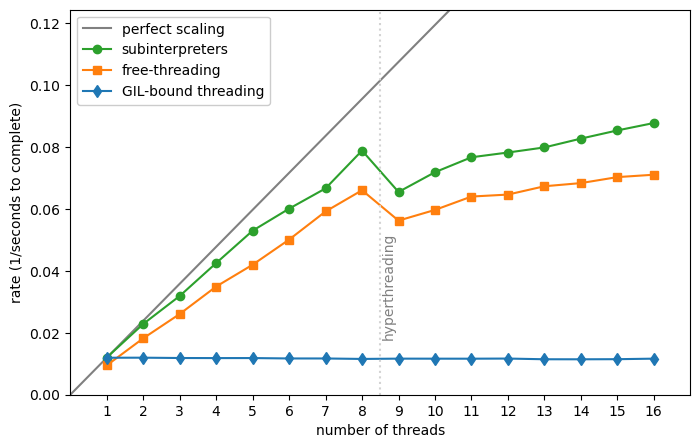

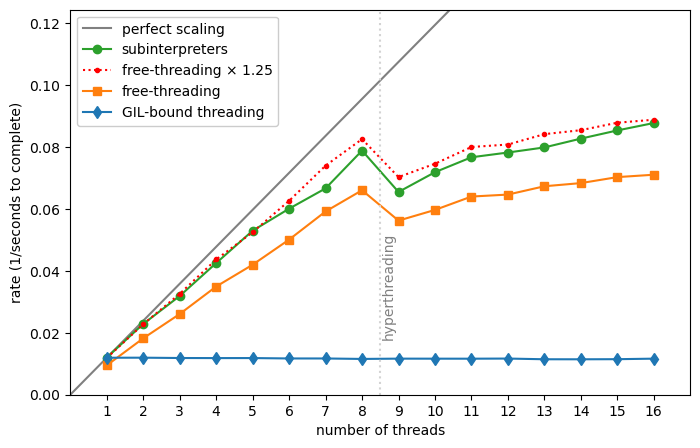

In [9]:
for which in ["basic", "extra"]:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(range(0, 17), [1/compute_threads_gil[0, 1] * i for i in range(0, 17)], color="gray", label="perfect scaling")
    
    ax.plot(range(1, 17), 1/compute_subinterpreter[:, 1], marker="o", color=green, ls="-", label="subinterpreters")
    if which == "extra":
        ax.plot(range(1, 17), 1/compute_threads_free[:, 1] * 1.25, marker=".", color="red", ls=":", label="free-threading × 1.25")
    ax.plot(range(1, 17), 1/compute_threads_free[:, 1], marker="s", color=orange, ls="-", label="free-threading")
    ax.plot(range(1, 17), 1/compute_threads_gil[:, 1], marker="d", color=blue, ls="-", label="GIL-bound threading")

    ax.axvline(8.5, color="lightgray", ls=":")
    ax.text(8.5, 0.035, "\nhyperthreading", color="gray", rotation="vertical", ha="center", va="center")
    
    ax.set_xlabel("number of threads")
    ax.set_ylabel("rate (1/seconds to complete)")
    ax.set_xticks(range(1, 17))
    ax.set_xlim(0, 17)
    ax.set_ylim(0, 1/compute_threads_free[-1, 1] * 1.75)

    ax.legend(loc="upper left", framealpha=1)

    fig.savefig(f"img/scaling-of-compute-{which}.svg")

In [10]:
cpu_calculate_subinterpreters_16 = np.asarray([0, 0.0, 10.0, 970.0, 1520, 1600, 1560, 1473, 1600, 1590, 1600, 1600, 1590, 1500, 1600, 1590, 1570, 1550, 1600, 1600, 1580, 1580, 1455, 1600, 1600, 1600, 1600, 1570, 1560, 1600, 1600, 1500, 1590, 1600, 1600, 1530, 1600, 1590, 1520, 1550, 1530, 1520, 1590, 1570, 1482, 1590, 1580, 1600, 1590, 1530, 1560, 1570, 1600, 1590, 1600, 1590, 1600, 1600, 1590, 1600, 1540, 1590, 1600, 1580, 1464, 1590, 1550, 1590, 1590, 1600, 1600, 1540, 1570, 1600, 1590, 1600, 1590, 1590, 1600, 1590, 1600, 1490, 1570, 1455, 1590, 1600, 1590, 1600, 1600, 1590, 1600, 1590, 1530, 1600, 1590, 1600, 1590, 1530, 1600, 1600, 1600, 1580, 1580, 1427, 1590, 1600, 1500, 1510, 1280, 1040, 1010, 880.0, 510.0, 100.0, 0.0, 0.0, 0])
cpu_calculate_subinterpreters_8 = np.asarray([0, 0.0, 320.0, 810.0, 810.0, 727.3, 800.0, 810.0, 810.0, 800.0, 810.0, 800.0, 800.0, 810.0, 810.0, 810.0, 790.0, 810.0, 810.0, 736.4, 800.0, 800.0, 810.0, 810.0, 810.0, 810.0, 790.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 810.0, 810.0, 800.0, 800.0, 800.0, 800.0, 736.4, 800.0, 800.0, 800.0, 810.0, 810.0, 800.0, 800.0, 810.0, 790.0, 810.0, 800.0, 800.0, 810.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 800.0, 810.0, 810.0, 800.0, 727.3, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 820.0, 800.0, 810.0, 790.0, 800.0, 810.0, 800.0, 800.0, 810.0, 800.0, 736.4, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 810.0, 800.0, 800.0, 800.0, 810.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 654.5, 550.0, 500.0, 500.0, 500.0, 400.0, 400.0, 320.0, 250.0, 20.0, 0.0, 0.0, 0])
cpu_calculate_free_threading_16 = np.asarray([0, 0.0, 1600, 1580, 1600, 1600, 1590, 1600, 1560, 1580, 1464, 1600, 1600, 1570, 1600, 1590, 1600, 1600, 1570, 1540, 1455, 1600, 1600, 1590, 1520, 1530, 1560, 1530, 1580, 1550, 1540, 1427, 1590, 1600, 1600, 1600, 1590, 1600, 1500, 1590, 1570, 1600, 1590, 1600, 1540, 1580, 1600, 1600, 1590, 1482, 1600, 1550, 1590, 1590, 1600, 1600, 1590, 1600, 1600, 1473, 1570, 1600, 1530, 1590, 1480, 1430, 1500, 1590, 1480, 1520, 1418, 1310, 1550, 1530, 1600, 1540, 1600, 1600, 1600, 1464, 1600, 1590, 1600, 1570, 1560, 1600, 1580, 1600, 1600, 1600, 1473, 1590, 1600, 1600, 1550, 1550, 1590, 1600, 1600, 1600, 1590, 1600, 1580, 1580, 1464, 1570, 1520, 1600, 1600, 1590, 1600, 1600, 1600, 1590, 1590, 1590, 1400, 1600, 1600, 1590, 1570, 1480, 1510, 1540, 1590, 1580, 1580, 1530, 1590, 1455, 1600, 1590, 1480, 1210, 1190, 940.0, 820.0, 630.0, 230.0, 0.0, 0.0, 0])
cpu_calculate_free_threading_8 = np.asarray([0, 0.0, 270.0, 800.0, 800.0, 727.3, 800.0, 810.0, 800.0, 800.0, 810.0, 800.0, 800.0, 810.0, 800.0, 800.0, 800.0, 810.0, 800.0, 800.0, 810.0, 800.0, 790.0, 810.0, 800.0, 810.0, 810.0, 800.0, 800.0, 800.0, 800.0, 736.4, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 810.0, 800.0, 800.0, 800.0, 810.0, 800.0, 810.0, 790.0, 800.0, 810.0, 800.0, 820.0, 800.0, 800.0, 800.0, 800.0, 800.0, 810.0, 790.0, 810.0, 727.3, 800.0, 820.0, 800.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 810.0, 800.0, 800.0, 800.0, 810.0, 727.3, 800.0, 810.0, 800.0, 800.0, 810.0, 800.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 790.0, 810.0, 810.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 736.4, 800.0, 800.0, 800.0, 800.0, 820.0, 800.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 810.0, 810.0, 800.0, 810.0, 800.0, 800.0, 800.0, 800.0, 800.0, 810.0, 800.0, 736.4, 800.0, 790.0, 810.0, 800.0, 810.0, 800.0, 800.0, 810.0, 770.0, 630.0, 610.0, 600.0, 610.0, 530.0, 430.0, 400.0, 270.0, 60.0, 0.0, 0.0, 0])
cpu_calculate_gil_threading_16 = np.asarray([0, 0.0, 9.1, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 90.9, 110.0, 110.0, 100.0, 100.0, 110.0, 90.0, 110.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 90.9, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 90.9, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 90.9, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 90.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 100.0, 120.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 90.9, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 90.9, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 120.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 120.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.0, 120.0, 100.0, 100.0, 100.0, 110.0, 90.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 90.0, 110.0, 100.0, 110.0, 100.0, 100.0, 90.9, 100.0, 110.0, 110.0, 100.0, 90.0, 110.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 90.9, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 90.9, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 90.9, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 90.9, 110.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 110.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 100.0, 100.0, 120.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 90.9, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 90.9, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 120.0, 100.0, 100.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 120.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 120.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 0.0, 0.0, 0])
cpu_calculate_gil_threading_2 = np.asarray([0, 0.0, 90.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.0, 110.0, 100.0, 100.0, 110.0, 100.0, 90.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 110.0, 90.0, 100.0, 110.0, 90.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.0, 110.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 0.0, 0.0, 0])
cpu_calculate_gil_threading_1 = np.asarray([0, 0.0, 90.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 110.0, 90.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 90.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 110.0, 90.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 90.9, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 110.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 10.0, 0.0, 0.0, 0])

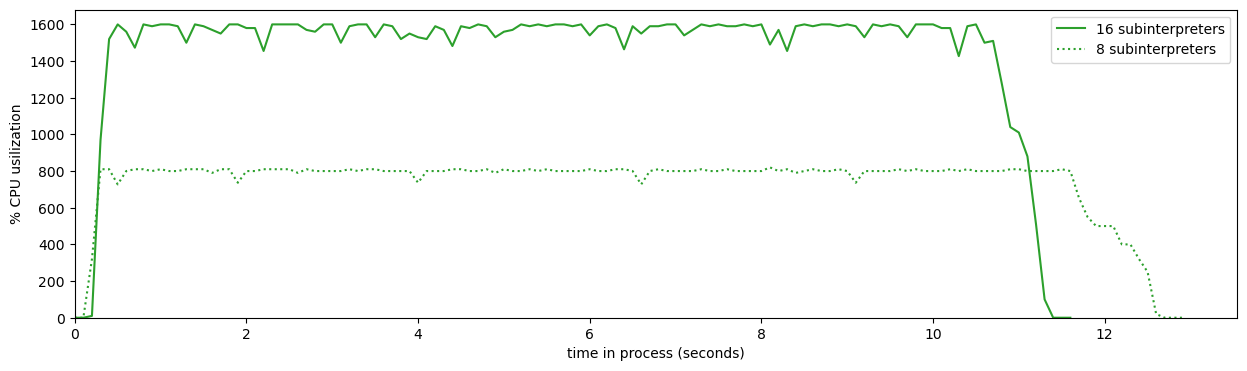

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(np.arange(0, len(cpu_calculate_subinterpreters_16)) * 0.1, cpu_calculate_subinterpreters_16, color=green, label="16 subinterpreters")
ax.plot(np.arange(0, len(cpu_calculate_subinterpreters_8)) * 0.1, cpu_calculate_subinterpreters_8, color=green, ls=":", label="8 subinterpreters")

ax.set_xlabel("time in process (seconds)")
ax.set_ylabel("% CPU usilization")
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])

ax.legend(loc="upper right")

fig.savefig("img/cpu-of-compute-subinterpreters.svg")

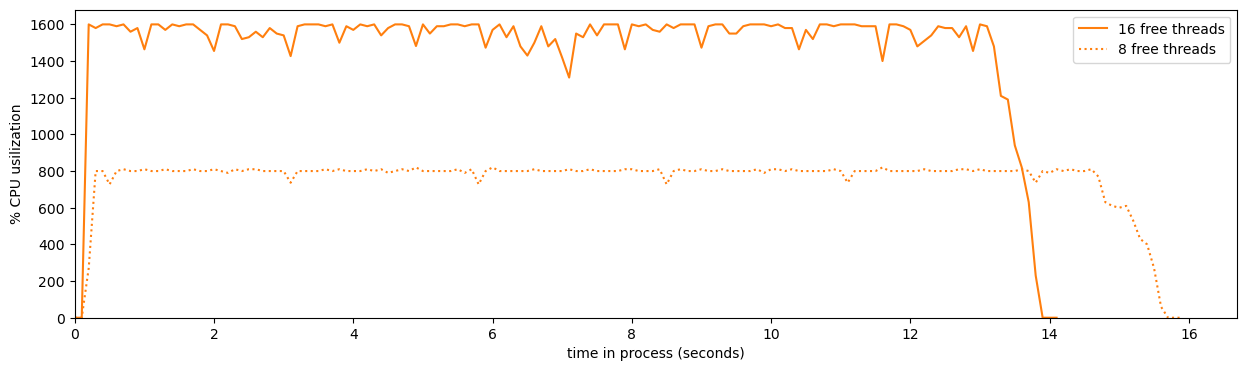

In [12]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(np.arange(0, len(cpu_calculate_free_threading_16)) * 0.1, cpu_calculate_free_threading_16, color=orange, label="16 free threads")
ax.plot(np.arange(0, len(cpu_calculate_free_threading_8)) * 0.1, cpu_calculate_free_threading_8, color=orange, ls=":", label="8 free threads")

ax.set_xlabel("time in process (seconds)")
ax.set_ylabel("% CPU usilization")
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])

ax.legend(loc="upper right")

fig.savefig("img/cpu-of-compute-free-threads.svg")

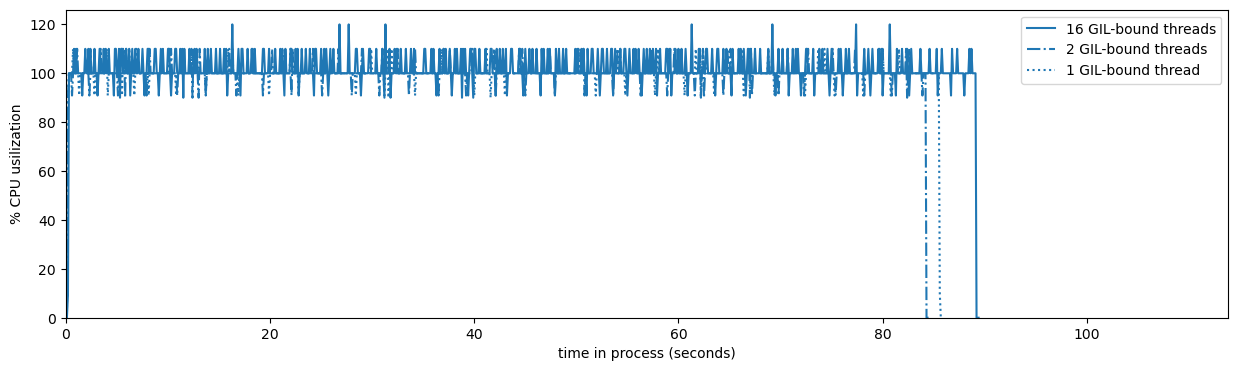

In [13]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(np.arange(0, len(cpu_calculate_gil_threading_16)) * 0.1, cpu_calculate_gil_threading_16, color=blue, label="16 GIL-bound threads")
ax.plot(np.arange(0, len(cpu_calculate_gil_threading_2)) * 0.1, cpu_calculate_gil_threading_2, color=blue, ls="-.", label="2 GIL-bound threads")
ax.plot(np.arange(0, len(cpu_calculate_gil_threading_1)) * 0.1, cpu_calculate_gil_threading_1, color=blue, ls=":", label="1 GIL-bound thread")

ax.set_xlabel("time in process (seconds)")
ax.set_ylabel("% CPU usilization")
ax.set_xlim(0, ax.get_xlim()[1] + 20)
ax.set_ylim(0, ax.get_ylim()[1])

ax.legend(loc="upper right")

fig.savefig("img/cpu-of-compute-gil-threads.svg")

# What are the consequences for Uproot?

Only free-threading, since `import numpy` crashes when run in a subinterpreter.

The `uproot_typical` are when Uproot is run inside of a parallel process, such as Dask-in-threads. Separate threads might read the same TBaskets if the entries divided among them don't align with TBasket boundaries. But each Uproot function call is completely isolated from the others, embarrassingly parallel, and one doesn't have to wait for another.

The `uproot_easy` is when you just pass a `ThreadPoolExector` to Uproot's `decompression_executor` and `interpretation_executor` arguments, so that Uproot internally parallelizes a single array read. The function call blocks until it's done, but Uproot can take advantage of more fine-grained parallelism and doesn't redundantly read any TBaskets.

In [14]:
uproot_typical_mm_gil = np.asarray(sorted([
    [13, 9.59248870400188],
    [5, 14.059066415997222],
    [14, 10.27972274300555],
    [6, 14.584184241000912],
    [2, 30.060350352003297],
    [7, 11.842124709997734],
    [12, 10.350878542005375],
    [10, 10.625854314996104],
    [3, 22.81008100300096],
    [8, 11.404914880004071],
    [1, 49.48106663500221],
    [9, 10.399582760001067],
    [11, 9.899742738001805],
    [15, 9.479201458001626],
    [4, 18.328884319998906],
    [16, 10.28526619400509],
]))

In [15]:
uproot_typical_not_gil = np.asarray(sorted([
    [13, 14.14578354400146],
    [5, 21.06571112700476],
    [14, 13.944951883997419],
    [6, 19.842704700000468],
    [2, 43.95790247900004],
    [7, 17.215840482000203],
    [12, 13.471893788999296],
    [10, 14.055023304994393],
    [3, 32.51204171299469],
    [8, 16.078223055999842],
    [1, 64.98935059900396],
    [9, 14.362278350999986],
    [11, 13.69559148499684],
    [15, 14.07600776500476],
    [4, 25.747839984003804],
    [16, 13.973729080993508],
]))

In [16]:
uproot_easy_mm_gil = np.asarray(sorted([
    [13, 9.824172649998218],
    [5, 12.936378218997561],
    [14, 9.812644438999996],
    [6, 11.745848683000077],
    [2, 25.48194209000212],
    [7, 10.927943008005968],
    [12, 9.780306690998259],
    [10, 10.02379617599945],
    [3, 18.376605741003004],
    [8, 10.390077121999639],
    [1, 45.88206718899892],
    [9, 10.174233850993915],
    [11, 9.945451081999636],
    [15, 9.799103158002254],
    [4, 14.830694169999333],
    [16, 9.845973457006039],
]))

In [17]:
uproot_easy_not_gil = np.asarray(sorted([
    [13, 16.597702600993216],
    [5, 19.389530205000483],
    [14, 16.578941810003016],
    [6, 18.081441816000734],
    [2, 31.644254915998317],
    [7, 17.416213778000383],
    [12, 16.69787936999637],
    [10, 16.81092931499734],
    [3, 24.70439708699996],
    [8, 16.99961976299528],
    [1, 52.671517272996425],
    [9, 16.640721805000794],
    [11, 16.646408902000985],
    [15, 16.583125946999644],
    [4, 21.24739167199732],
    [16, 16.834511084998667],
]))

In [18]:
uproot_typical_mm_free = np.asarray(sorted([
    [13, 10.309948158996121],
    [5, 14.13221426900418],
    [14, 9.506540331996803],
    [6, 14.684840386005817],
    [2, 30.93215859799966],
    [7, 11.30193628500274],
    [12, 8.827063090997399],
    [10, 9.733047709996754],
    [3, 22.67955571499624],
    [8, 11.59353119199659],
    [1, 49.58972105299472],
    [9, 10.236410823003098],
    [11, 10.226104802000918],
    [15, 9.526255892000336],
    [4, 18.552851191001537],
    [16, 9.608044941000117],
]))

In [19]:
uproot_typical_not_free = np.asarray(sorted([
    [13, 12.608314930999768],
    [5, 18.61725870200462],
    [14, 11.503342418000102],
    [6, 18.678357875003712],
    [2, 44.685668632999295],
    [7, 14.781213549002132],
    [12, 11.517531268000312],
    [10, 12.191478495005867],
    [3, 32.19530788100383],
    [8, 14.384883575999993],
    [1, 74.29932120999729],
    [9, 12.407427469996037],
    [11, 12.408198876000824],
    [15, 11.673952210003335],
    [4, 24.082837451998785],
    [16, 11.258088747003058],
]))

In [20]:
uproot_easy_mm_free = np.asarray(sorted([
    [13, 9.424774745002651],
    [5, 12.76675399099986],
    [14, 9.241204064001067],
    [6, 11.44970464400103],
    [2, 26.416630285999418],
    [7, 10.689936761002173],
    [12, 9.525186879000103],
    [10, 9.765235386999848],
    [3, 18.634904406000715],
    [8, 10.119304739000654],
    [1, 49.90675139099767],
    [9, 9.883504535999236],
    [11, 9.635315425999579],
    [15, 9.240718678000121],
    [4, 14.884990222999477],
    [16, 9.074809541998548],
]))

In [21]:
uproot_easy_not_free = np.asarray(sorted([
    [13, 15.677327389999846],
    [5, 19.24547866300054],
    [14, 16.435240097998758],
    [6, 18.508096484998532],
    [2, 33.7611019879987],
    [7, 17.909479554000427],
    [12, 15.817716262998147],
    [10, 15.599392209001962],
    [3, 26.10267138999916],
    [8, 16.867974447999586],
    [1, 60.0708828909992],
    [9, 16.38504439299868],
    [11, 16.242958571998315],
    [15, 16.255379204001656],
    [4, 22.1854385810002],
    [16, 15.56872584499797],
]))

### External parallelization

Uproot being called by separate threads on different entry ranges (but they might redundantly read edge-TBaskets):

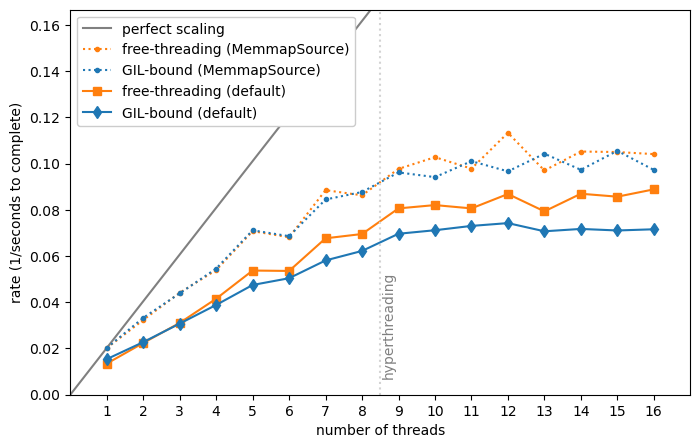

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(range(0, 17), [1/uproot_typical_mm_gil[0, 1] * i for i in range(0, 17)], color="gray", label="perfect scaling")

ax.plot(range(1, 17), 1/uproot_typical_mm_free[:, 1], marker=".", color=orange, ls=":", label="free-threading (MemmapSource)")
ax.plot(range(1, 17), 1/uproot_typical_mm_gil[:, 1], marker=".", color=blue, ls=":", label="GIL-bound (MemmapSource)")

ax.plot(range(1, 17), 1/uproot_typical_not_free[:, 1], marker="s", color=orange, ls="-", label="free-threading (default)")
ax.plot(range(1, 17), 1/uproot_typical_not_gil[:, 1], marker="d", color=blue, ls="-", label="GIL-bound (default)")

ax.axvline(8.5, color="lightgray", ls=":")
ax.text(8.5, 0.03, "\nhyperthreading", color="gray", rotation="vertical", ha="center", va="center")

ax.set_xlabel("number of threads")
ax.set_ylabel("rate (1/seconds to complete)")
ax.set_xticks(range(1, 17))
ax.set_xlim(0, 17)
ax.set_ylim(0, 1/uproot_typical_mm_free[-1, 1] * 1.6)

ax.legend(loc="upper left", framealpha=1)

fig.savefig("img/scaling-of-uproot-external.svg")

### Internal parallelization

Urpoot being called once with `decompression_executor` and `interpretation_executor`:

```python
executor = ThreadPoolExecutor(max_workers=NUM_THREADS)

for array in uproot.iterate(
    [
        "/home/jpivarski/Downloads/Run2012B_DoubleMuParked.root:Events",
        "/home/jpivarski/Downloads/Run2012C_DoubleMuParked.root:Events",
    ],
    decompression_executor=executor,
    interpretation_executor=executor,
    handler=SOURCE,
    step_size="1 GB",
):
    del array
```

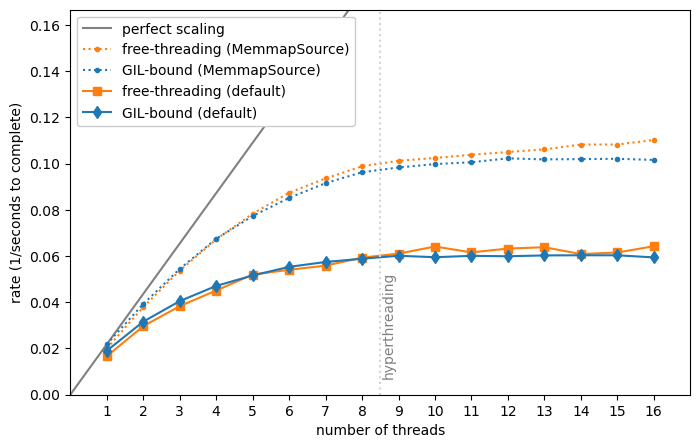

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(range(0, 17), [1/uproot_easy_mm_gil[0, 1] * i for i in range(0, 17)], color="gray", label="perfect scaling")

ax.plot(range(1, 17), 1/uproot_easy_mm_free[:, 1], marker=".", color=orange, ls=":", label="free-threading (MemmapSource)")
ax.plot(range(1, 17), 1/uproot_easy_mm_gil[:, 1], marker=".", color=blue, ls=":", label="GIL-bound (MemmapSource)")

ax.plot(range(1, 17), 1/uproot_easy_not_free[:, 1], marker="s", color=orange, ls="-", label="free-threading (default)")
ax.plot(range(1, 17), 1/uproot_easy_not_gil[:, 1], marker="d", color=blue, ls="-", label="GIL-bound (default)")

ax.axvline(8.5, color="lightgray", ls=":")
ax.text(8.5, 0.03, "\nhyperthreading", color="gray", rotation="vertical", ha="center", va="center")

ax.set_xlabel("number of threads")
ax.set_ylabel("rate (1/seconds to complete)")
ax.set_xticks(range(1, 17))
ax.set_xlim(0, 17)
ax.set_ylim(0, 1/uproot_typical_mm_free[-1, 1] * 1.6)

ax.legend(loc="upper left", framealpha=1)

fig.savefig("img/scaling-of-uproot-internal.svg")

In [24]:
cpu_uproot_easy_mm_gil = np.array([0, 766.7, 470.0, 1350, 1220, 1230, 1130, 1360, 1070, 836.4, 600.0, 350.0, 470.0, 590.0, 860.0, 720.0, 120.0, 110.0, 720.0, 1127, 1180, 1200, 1300, 1160, 830.0, 780.0, 440.0, 720.0, 1000, 900.0, 820.0, 370.0, 580.0, 1390, 1150, 1390, 1220, 1000, 736.4, 510.0, 620.0, 930.0, 1120, 850.0, 700.0, 850.0, 681.8, 180.0, 90.0, 440.0, 1470, 1200, 1420, 1330, 1150, 880.0, 450.0, 820.0, 1030, 1060, 880.0, 227.3, 850.0, 1430, 1240, 1430, 1220, 1110, 410.0, 590.0, 960.0, 1160, 920.0, 518.2, 670.0, 1440, 1250, 1430, 1300, 980.0, 520.0, 530.0, 900.0, 1090, 850.0, 510.0, 670.0, 1310, 1260, 1273, 1320, 1000, 630.0, 530.0, 850.0, 1110, 970.0, 600.0, 940.0, 1380, 1010, 440.0, 472.7, 100.0, 100.0, 100.0, 100.0, 100.0, 0])
cpu_uproot_easy_mm_free = np.array([0, 760.0, 100.0, 780.0, 1240, 1560, 1600, 1600, 1336, 1440, 1100, 890.0, 570.0, 1480, 1440, 520.0, 272.7, 1330, 1580, 1600, 1580, 1580, 1490, 1300, 1450, 1490, 1364, 1220, 640.0, 1510, 1464, 1570, 1570, 1510, 1400, 1490, 1510, 1520, 1327, 930.0, 1460, 940.0, 100.0, 1160, 1580, 1540, 1600, 1436, 1580, 1490, 1500, 1490, 1500, 1373, 720.0, 1170, 1580, 1590, 1590, 1590, 1550, 1490, 1373, 1540, 1480, 980.0, 1020, 1590, 1580, 1600, 1580, 1391, 1530, 1520, 1364, 1480, 1140, 940.0, 1600, 1600, 1580, 1318, 1490, 1490, 1530, 1450, 1480, 1255, 1060, 1455, 1540, 1480, 1530, 330.0, 340.0, 230.0, 100.0, 100.0, 100.0, 0])

Uproot's not always keeping the CPUs busy, even in the best case (internal parallelization with `MemmapSource`):

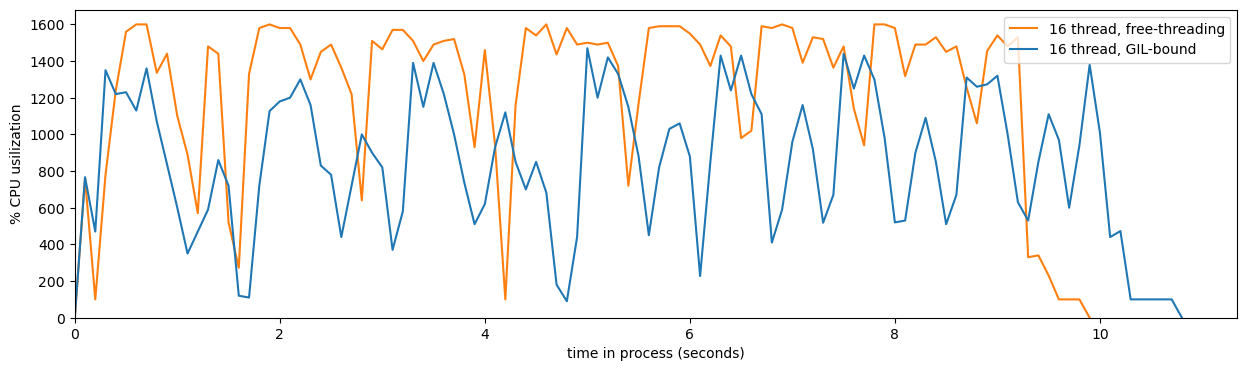

In [25]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(np.arange(0, len(cpu_uproot_easy_mm_free)) * 0.1, cpu_uproot_easy_mm_free, color=orange, label="16 thread, free-threading")
ax.plot(np.arange(0, len(cpu_uproot_easy_mm_gil)) * 0.1, cpu_uproot_easy_mm_gil, color=blue, label="16 thread, GIL-bound")

ax.set_xlabel("time in process (seconds)")
ax.set_ylabel("% CPU usilization")
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])

ax.legend(loc="upper right")

fig.savefig("img/cpu-of-uproot-internal-16.svg")

Uproot was already offloading work to extension modules that released the GIL.

Because external code is interleaved with Python code, there's some opportunity for improvement.

But it's nothing compared to bigger considerations, like the file I/O source. (Note: this is all warm cache; disk speeds are not a factor.)

TIL that `uproot.MemmapSource` would be a better default than `uproot.FSSpecSource`, but you mostly see the difference in parallel processing.